# Lung and Colon Cancer Detection

##   Importing Libraries

In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

## Importing Dataset

In [4]:
path=r"C:\Users\elain\coding\Notebook\Lung and colon disease\lung and colon"
classes = os.listdir(path)
classes

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

## Data Preprocessing

### Creating labels

In [2]:
cls = {
    'Colon adenocarcinoma': 0,
    'Colon Normal': 1,
    'Lung adenocarcinoma': 2,
    'Lung Normal': 3,
    'Lung squamous cell carcinoma': 4,
    
}
cls_list = list(cls.items())

#Example
index = 2 
class_name, numeric_label = cls_list[index]
print(f"Class name at index {index}: {class_name}")
print(f"Numeric label at index {index}: {numeric_label}")

Class name at index 2: Lung adenocarcinoma
Numeric label at index 2: 2


###  Defining X and Y

In [5]:
X = []
Y = []

for i,cat in enumerate(classes):
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
    
    for _ in range(5000):
        k = np.random.randint(0, len(images))
        img_path = os.path.join(image_dir, images[k])
        img = cv2.imread(img_path)
        
        # Resize 
        resize = cv2.resize(img, (128, 128))
        
        # Grayscale
        gray = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)

        #Histogram Equalization
        equ = cv2.equalizeHist(gray) 
        equ_3ch = np.stack((equ,)*3, axis=-1)
        
        #Class label,Numeric label
        class_name, numeric_label = cls_list[i]

        X.append(equ_3ch)
        Y.append(numeric_label)


In [6]:
X = np.array(X)
Y = np.array(Y)


Y = to_categorical(Y, num_classes=5)

print(f'X shape: {X.shape}')
print(f'Y shape: {Y.shape}')

X shape: (25000, 128, 128, 3)
Y shape: (25000, 5)


### Splitting the data

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y,test_size = 0.2, random_state = 2022)
print(X_train.shape, Y_train.shape)

(20000, 128, 128, 3) (20000, 5)


##### Data augmentation

In [7]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

MemoryError: Unable to allocate 3.66 GiB for an array with shape (20000, 128, 128, 3) and data type float32

## Building model

In [ ]:
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(cls), activation='softmax')
])

In [ ]:
model.summary()

### Compile

In [ ]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)

### Train

In [ ]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
                    validation_data=(X_val, Y_val),
                    epochs=10)


In [12]:
%store history

Stored 'history' (History)


In [31]:
%store -r history

#### Plot training & validation accuracy values

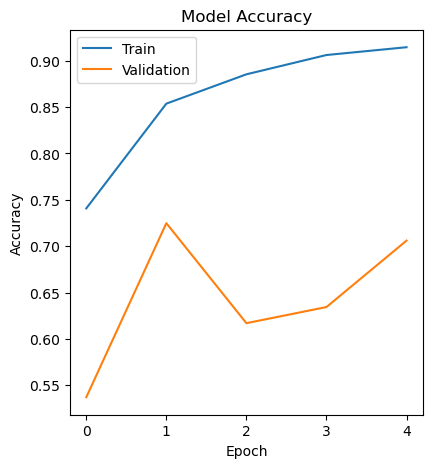

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Plot training & validation loss values

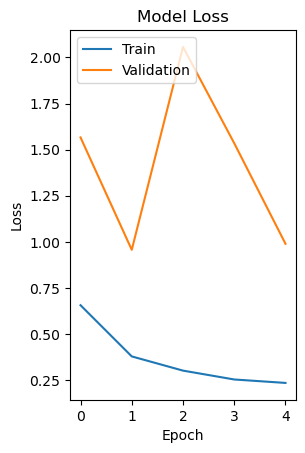

In [11]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Predict

In [12]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step


In [13]:
print("Shape of Y_val:", Y_val.shape)
print("Shape of Y_pred:", Y_pred.shape)

Shape of Y_val: (5000,)
Shape of Y_pred: (5000,)


#### Plotting predicted and true labels

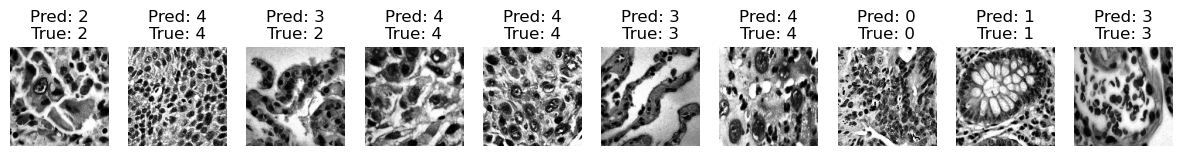

In [14]:
fig, ax = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    img = X_val[i]
    predicted_label = Y_pred[i]
    true_label = Y_val[i]

    ax[i].imshow(img)
    ax[i].set_title(f'Pred: {predicted_label}\nTrue: {true_label}')
    ax[i].axis('off')

plt.show()

## Confusion Matrix

In [15]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics 

In [16]:
confusion_matrix = metrics.confusion_matrix(Y_val, Y_pred)

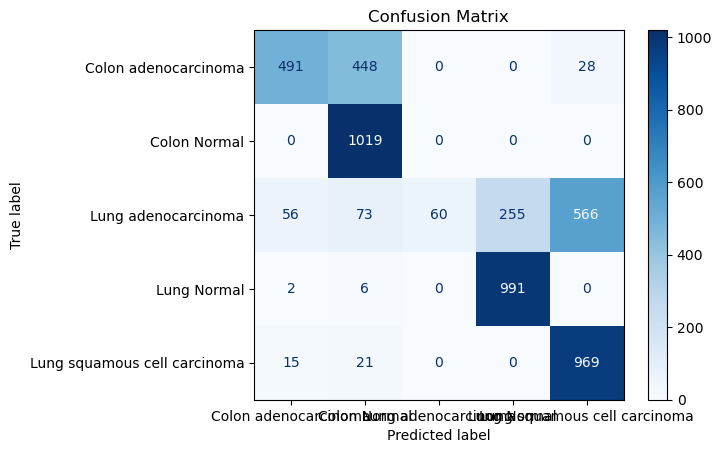

In [17]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, 
                                            display_labels=['Colon adenocarcinoma', 'Colon Normal', 'Lung adenocarcinoma', 
                                                            'Lung Normal','Lung squamous cell carcinoma' ])
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## Classification report

In [18]:
print(metrics.classification_report(Y_val, Y_pred, target_names=['Colon adenocarcinoma', 'Colon Normal', 'Lung adenocarcinoma', 
                                                            'Lung Normal','Lung squamous cell carcinoma' ]))


                              precision    recall  f1-score   support

        Colon adenocarcinoma       0.87      0.51      0.64       967
                Colon Normal       0.65      1.00      0.79      1019
         Lung adenocarcinoma       1.00      0.06      0.11      1010
                 Lung Normal       0.80      0.99      0.88       999
Lung squamous cell carcinoma       0.62      0.96      0.75      1005

                    accuracy                           0.71      5000
                   macro avg       0.79      0.70      0.64      5000
                weighted avg       0.79      0.71      0.64      5000



## Performance metrics

In [19]:
accuracy = accuracy_score(Y_val, Y_pred)
precision = precision_score(Y_val, Y_pred, average='weighted')
recall = recall_score(Y_val, Y_pred, average='weighted')
f1 = f1_score(Y_val, Y_pred, average='weighted')

In [20]:
print("Overall Performance Metrics:")
print("Accuracy:", accuracy)
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1 Score:", f1)

Overall Performance Metrics:
Accuracy: 0.706
Weighted Precision: 0.7864184922570234
Weighted Recall: 0.706
Weighted F1 Score: 0.6353985843276266


## Save

In [22]:
model.save('trained_lung_coloncnn.keras')

In [21]:
history.history

{'accuracy': [0.7407500147819519,
  0.8536499738693237,
  0.8852499723434448,
  0.9060500264167786,
  0.9144499897956848],
 'loss': [0.656562864780426,
  0.3790525794029236,
  0.302021861076355,
  0.253957599401474,
  0.2353259027004242],
 'val_accuracy': [0.5371999740600586,
  0.7247999906539917,
  0.6169999837875366,
  0.6344000101089478,
  0.7059999704360962],
 'val_loss': [1.566177487373352,
  0.9569258689880371,
  2.056774616241455,
  1.5345351696014404,
  0.9895836114883423]}

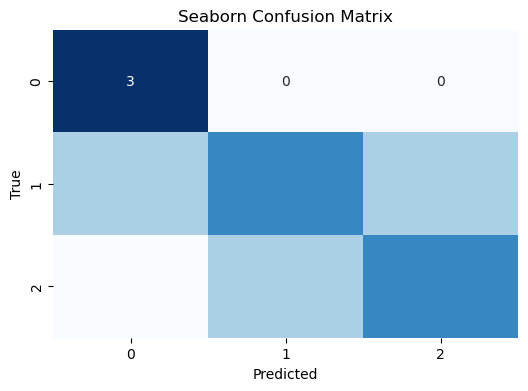

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Example data
true_labels = np.array([0, 1, 2, 0, 1, 2, 1, 0, 1, 2])
predicted_labels = np.array([0, 2, 1, 0, 0, 2, 1, 0, 1, 2])
cm = confusion_matrix(true_labels, predicted_labels)

# Plot with Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Seaborn Confusion Matrix')
plt.show()

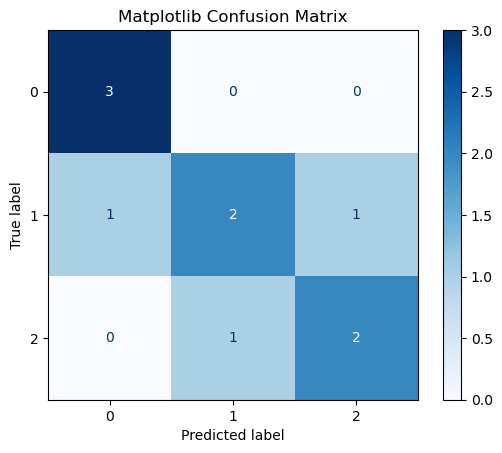

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Example data
true_labels = np.array([0, 1, 2, 0, 1, 2, 1, 0, 1, 2])
predicted_labels = np.array([0, 2, 1, 0, 0, 2, 1, 0, 1, 2])

# Plot with Matplotlib
disp = ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, cmap='Blues')
plt.title('Matplotlib Confusion Matrix')
plt.show()


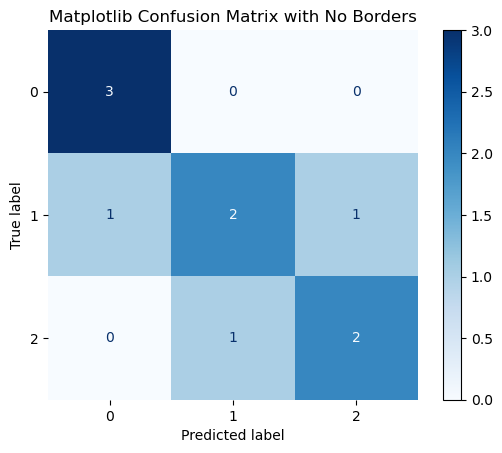

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Example data
true_labels = np.array([0, 1, 2, 0, 1, 2, 1, 0, 1, 2])
predicted_labels = np.array([0, 2, 1, 0, 0, 2, 1, 0, 1, 2])

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix with Matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax)

# Remove top and right spines (borders)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title('Matplotlib Confusion Matrix with No Borders')
plt.show()


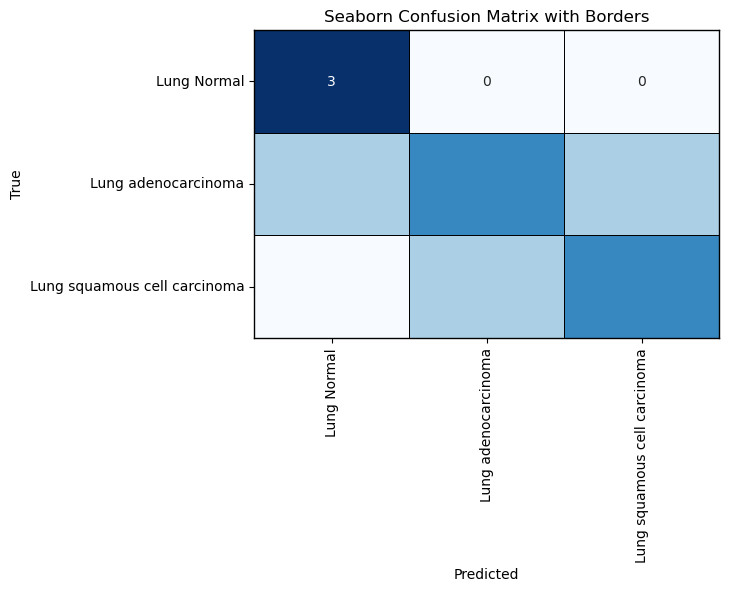

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Example data
true_labels = np.array([0, 1, 2, 0, 1, 2, 1, 0, 1, 2])
predicted_labels = np.array([0, 2, 1, 0, 0, 2, 1, 0, 1, 2])
cm = confusion_matrix(true_labels, predicted_labels)

# Define class labels
class_names = ['Lung Normal', 'Lung adenocarcinoma', 'Lung squamous cell carcinoma']

# Plot confusion matrix with Seaborn
plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                 xticklabels=class_names, yticklabels=class_names,
                 linewidths=0.5, linecolor='black')

# Customize spines (borders) around the entire plot
for _, spine in ax.spines.items():
    spine.set_visible(True)  # Make the spines visible
    spine.set_color('black') # Set the color of the spines
    spine.set_linewidth(1)   # Set the width of the spines

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Seaborn Confusion Matrix with Borders')
plt.show()


In [ ]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
path=r"C:\Users\elain\coding\Notebook\Lung and colon disease\lung and colon"
classes = os.listdir(path)
cls = {
    'Colon adenocarcinoma': 0,
    'Colon Normal': 1,
    'Lung adenocarcinoma': 2,
    'Lung Normal': 3,
    'Lung squamous cell carcinoma': 4,
    
}
cls_list = list(cls.items())
X = []
Y = []

for i,cat in enumerate(classes):
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
    
    for _ in range(5000):
        k = np.random.randint(0, len(images))
        img_path = os.path.join(image_dir, images[k])
        img = cv2.imread(img_path)
        
        # Resize 
        resize = cv2.resize(img, (128, 128))
        
        # Grayscale
        gray = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)

        #Histogram Equalization
        equ = cv2.equalizeHist(gray) 
        equ_3ch = np.stack((equ,)*3, axis=-1)
        
        #Class label,Numeric label
        class_name, numeric_label = cls_list[i]

        X.append(equ_3ch)
        Y.append(numeric_label)
        
X = np.array(X)
Y = np.array(Y)

X = X.astype('float32') / 255.0
Y = to_categorical(Y, num_classes=5)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y,test_size = 0.2, random_state = 2022)
print(X_train.shape, Y_train.shape)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(cls), activation='softmax')
])
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)
history = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
                    validation_data=(X_val, Y_val),
                    epochs=30)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)
fig, ax = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    img = X_val[i]
    predicted_label = Y_pred[i]
    true_label = Y_val[i]

    ax[i].imshow(img)
    ax[i].set_title(f'Pred: {predicted_label}\nTrue: {true_label}')
    ax[i].axis('off')

plt.show()
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics 
confusion_matrix = metrics.confusion_matrix(Y_val, Y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, 
                                            display_labels=['Colon adenocarcinoma', 'Colon Normal', 'Lung adenocarcinoma', 
                                                            'Lung Normal','Lung squamous cell carcinoma' ])
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
print(metrics.classification_report(Y_val, Y_pred, target_names=['Colon adenocarcinoma', 'Colon Normal', 'Lung adenocarcinoma', 
                                                            'Lung Normal','Lung squamous cell carcinoma' ]))
accuracy = accuracy_score(Y_val, Y_pred)
precision = precision_score(Y_val, Y_pred, average='weighted')
recall = recall_score(Y_val, Y_pred, average='weighted')
f1 = f1_score(Y_val, Y_pred, average='weighted')
print("Overall Performance Metrics:")
print("Accuracy:", accuracy)
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1 Score:", f1)